In [1]:
# libraries
import pymc as pm
import arviz as az
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import requests
import pandas as pd

In [4]:
# data 
url = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv'
data = [
    line.split(', ')
    for line in requests.get(url).text.strip().split('\n')
    if not line.startswith('"')]

for row in data:
    row[0] = datetime.datetime.strptime(row[0], '%Y-%m-%d')
    row[1] = float(row[1])

# Count the number of days from the first date and convert to years
first_date = datetime.datetime(1, 1, 1)  # data[0][0]
for row in data:
    row[0] = (row[0] - first_date).days / 365.25 + 1  # Years since the first date
# Convert to arrays
years = np.array([row[0] for row in data])
co2 = np.array([row[1] for row in data])

# Plot
xtick_offset = (datetime.datetime(1960, 1, 1) - first_date).days / 365.25
xtick_values = np.arange(xtick_offset, years[-1], 10)
xtick_labels = 1960 + np.arange(len(xtick_values)) * 10

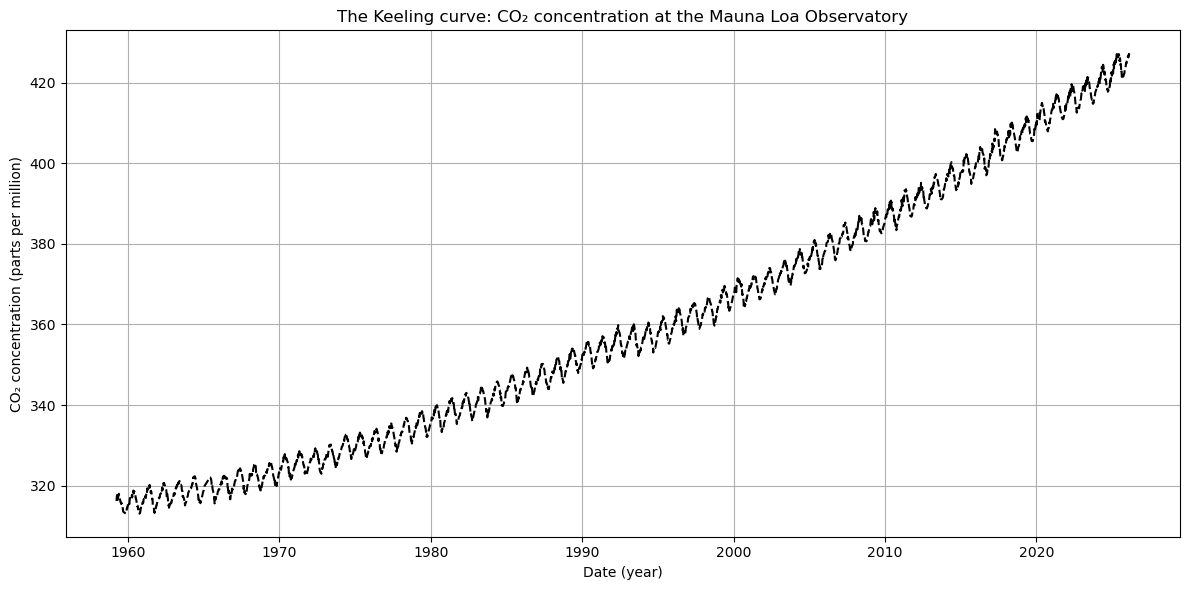

In [8]:
# Plot 
plt.figure(figsize=(12, 6))
plt.title('The Keeling curve: CO₂ concentration at the Mauna Loa Observatory')
plt.xlabel('Date (year)')
plt.ylabel('CO₂ concentration (parts per million)')
plt.plot(years, co2, 'k--')
plt.grid()
plt.tight_layout()
plt.xticks(xtick_values, xtick_labels)
plt.show()

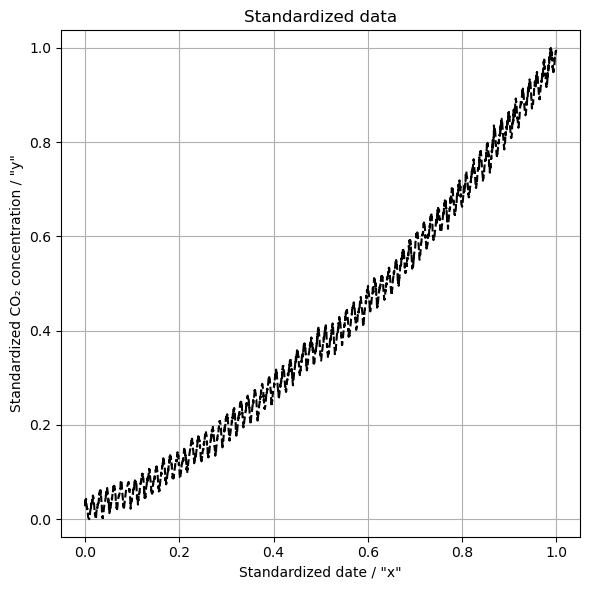

In [9]:
# standardize for analysis 
years_min = years[0]
years_range = years[-1] - years[0]
data_x = (years - years_min) / years_range

co2_min = np.min(co2)
co2_range = np.max(co2) - co2_min
data_y = (co2 - co2_min) / co2_range

plt.figure(figsize=(6, 6))
plt.title('Standardized data')
plt.xlabel('Standardized date / "x"')
plt.ylabel('Standardized CO₂ concentration / "y"')
plt.plot(data_x, data_y, 'k--')
plt.axis('equal')
plt.grid()
plt.tight_layout()
plt.show()

66.90485968514713

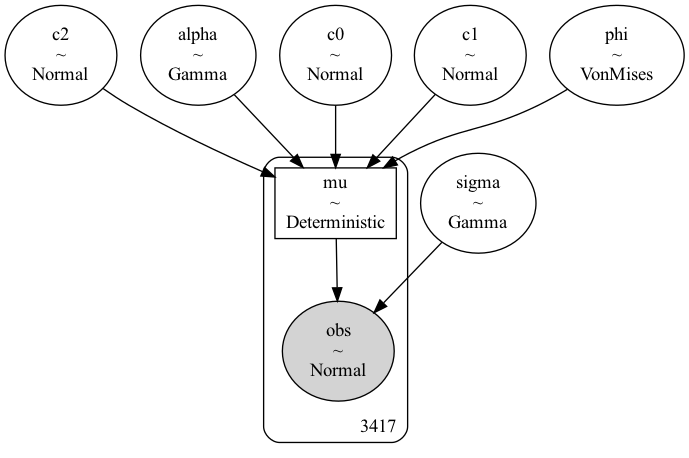

In [11]:
with pm.Model() as model:
    # Priors
    c0 = pm.Normal('c0', mu=0, sigma=1) # intercept
    c1 = pm.Normal('c1', mu=0, sigma=10) # linear term
    c2 = pm.Normal('c2', mu=0, sigma=10) # quadratic term
    alpha = pm.Gamma('alpha', mu=1, sigma=1) # variance
    phi = pm.VonMises('phi', mu=0, kappa=0.001) # Von Mises for seasonality
    sigma = pm.Gamma('sigma', mu=1, sigma=1) # noise
    # Likelihood
    mu = pm.Deterministic('mu', c0 + c1 * data_x + c2 * data_x**2 + alpha * pm.math.cos(2 * np.pi * years_range * data_x + phi))
    likelihood = pm.Normal('obs', mu=mu, sigma=sigma, observed=data_y)
from IPython.display import Image
Image(pm.model_to_graphviz(model).render(format='png'))

In [12]:
with model:
    inference = pm.sample()
    pm.compute_log_likelihood(inference)
display(az.summary(inference))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, c2, alpha, phi, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.016,0.000,0.015,0.017,0.0,0.0,1703.0,2326.0,1.0
c1,0.430,0.002,0.426,0.434,0.0,0.0,1512.0,2117.0,1.0
c2,0.532,0.002,0.528,0.536,0.0,0.0,1651.0,2170.0,1.0
alpha,0.025,0.000,0.025,0.025,0.0,0.0,3173.0,2354.0,1.0
phi,-0.407,0.008,-0.422,-0.391,0.0,0.0,2781.0,2242.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[3412],0.975,0.000,0.974,0.976,0.0,0.0,3039.0,3201.0,1.0
mu[3413],0.982,0.000,0.981,0.983,0.0,0.0,3070.0,3147.0,1.0
mu[3414],0.985,0.000,0.984,0.986,0.0,0.0,3088.0,3271.0,1.0
mu[3415],0.988,0.000,0.988,0.989,0.0,0.0,3112.0,3211.0,1.0


/Users/giorgikukishvili/Documents/Giorgi/anaconda3/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


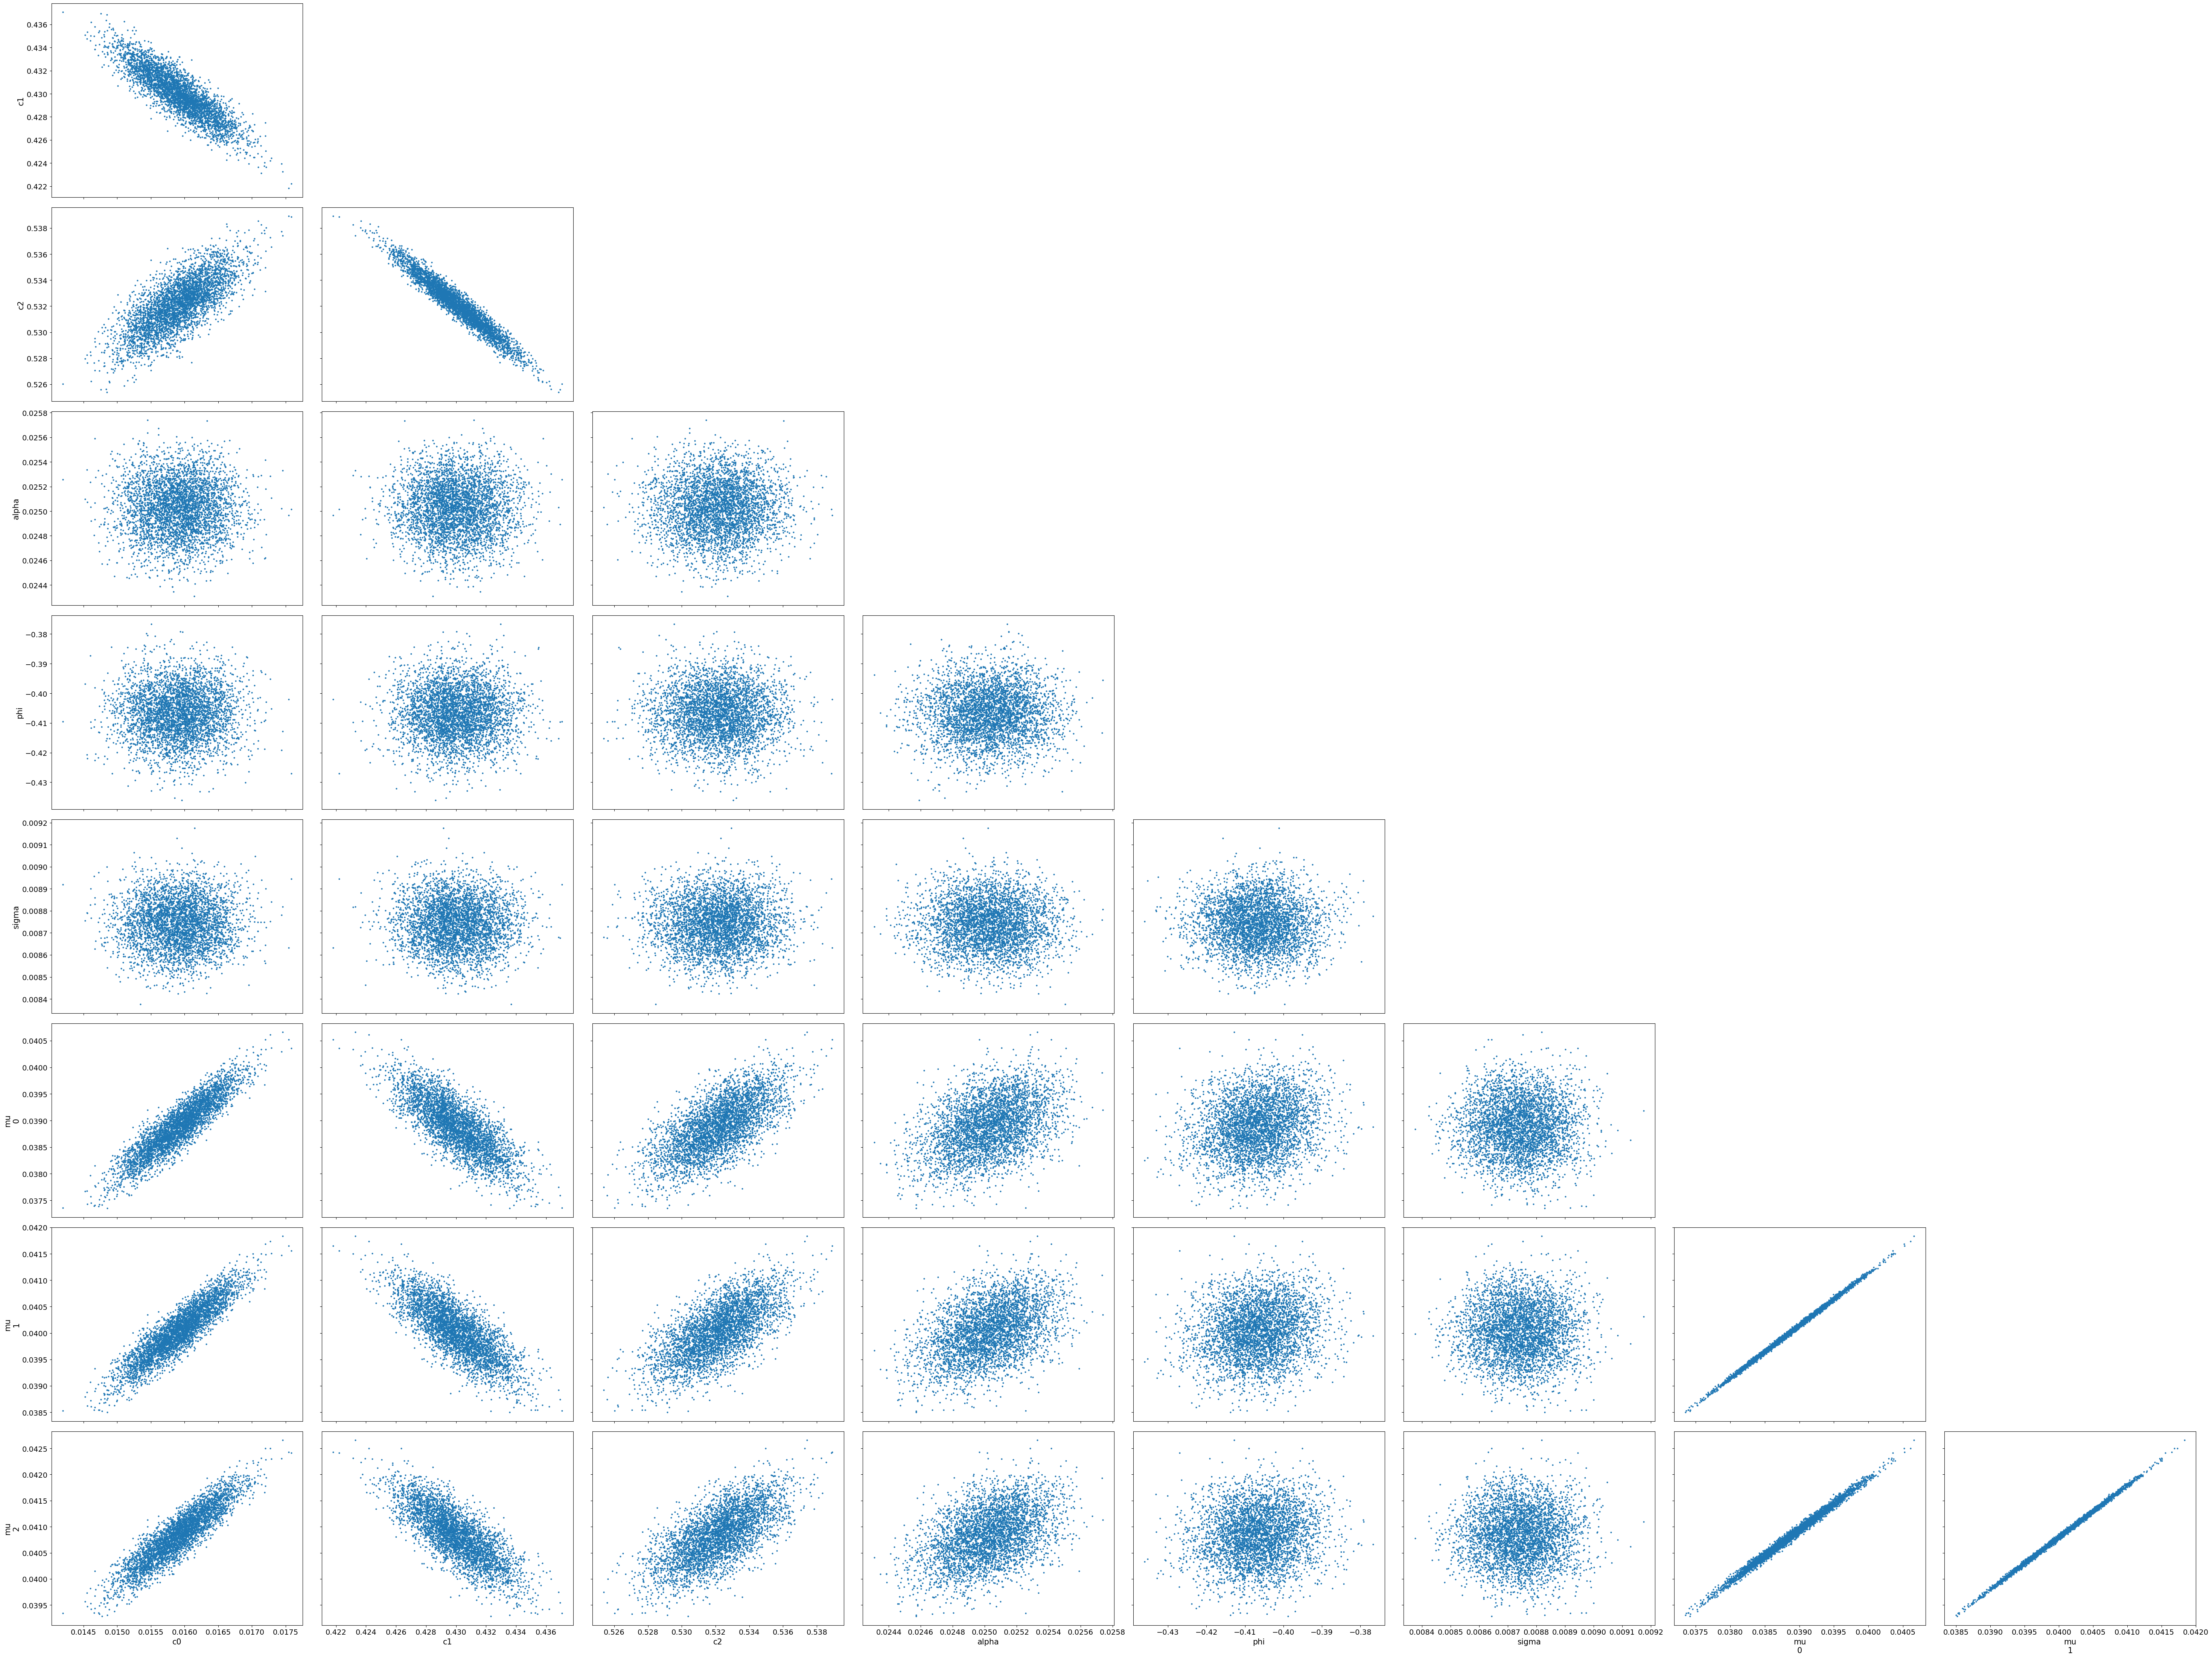

In [13]:
az.plot_pair(inference)
plt.tight_layout()

Sampling: [obs]


Output()

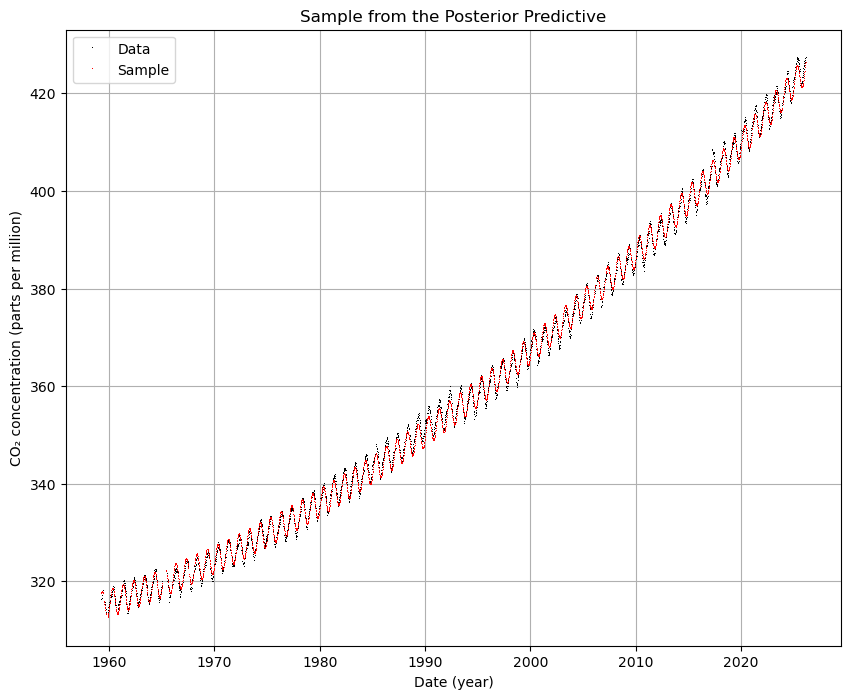

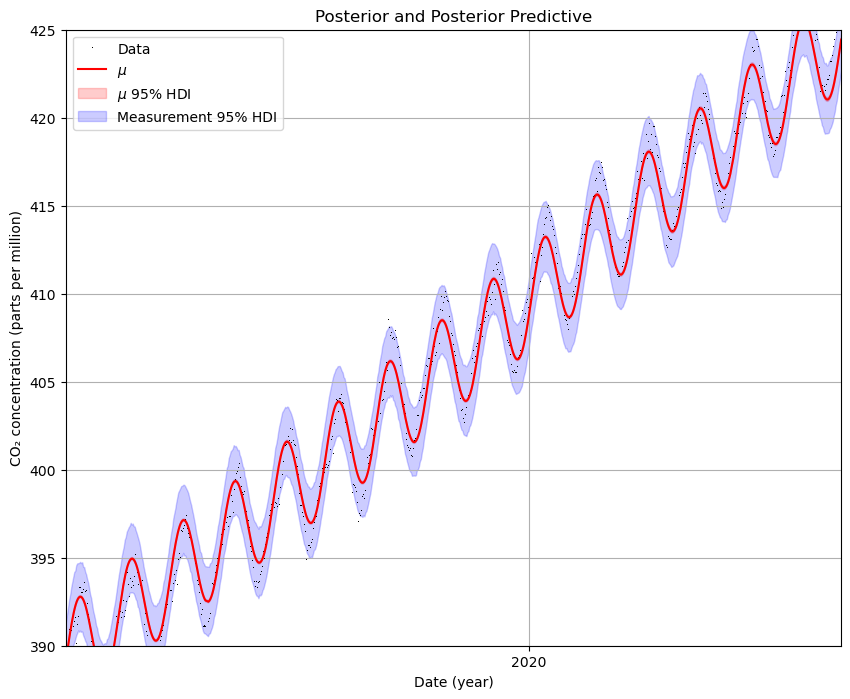

In [17]:
# Sample from the posterior predictive distribution
with model:
    pm.sample_posterior_predictive(inference, extend_inferencedata=True)

# Extract mean and observed values
mu = inference.posterior["mu"].values
obs = inference.posterior_predictive["obs"].values

# Plot posterior predictive samples
plt.figure(figsize=(10, 8))
plt.title("Sample from the Posterior Predictive")
plt.xlabel("Date (year)")
plt.ylabel("CO₂ concentration (parts per million)")
plt.plot(years, co2, "k,", label="Data")
plt.plot(years, np.mean(obs, axis=(0, 1)) * co2_range + co2_min, "r,", label="Sample") 
plt.xticks(xtick_values, xtick_labels)
plt.legend()
plt.grid()
plt.show()

# Plot posterior and posterior predictive
plt.figure(figsize=(10, 8))
plt.title("Posterior and Posterior Predictive")
plt.xlabel("Date (year)")
plt.ylabel("CO₂ concentration (parts per million)")
plt.plot(years, co2, "k,", label="Data")
plt.plot(years, np.mean(mu, axis=(0, 1)) * co2_range + co2_min, "r-", label=r"$\mu$")
plt.fill_between(
    years,
    np.percentile(mu, 2.5, axis=(0, 1)) * co2_range + co2_min,
    np.percentile(mu, 97.5, axis=(0, 1)) * co2_range + co2_min,
    color="r",
    alpha=0.2,
    label=r"$\mu$ 95% HDI",
)
plt.fill_between(
    years,
    np.percentile(obs, 2.5, axis=(0, 1)) * co2_range + co2_min,
    np.percentile(obs, 97.5, axis=(0, 1)) * co2_range + co2_min,
    color="b",
    alpha=0.2,
    label="Measurement 95% HDI",
)
plt.xticks(xtick_values, xtick_labels)
plt.xlim(2010, 2025)
plt.ylim(390, 425)
plt.legend()
plt.grid()
plt.show()


In [47]:
print(np.percentile(mu, [2.5, 97.5], axis=(0, 1)))

[[0.03789702 0.03903605 0.03984032 ... 0.97132196 0.97475047 0.98159175]
 [0.03986724 0.04102108 0.04182248 ... 0.97323695 0.97665754 0.98351697]]


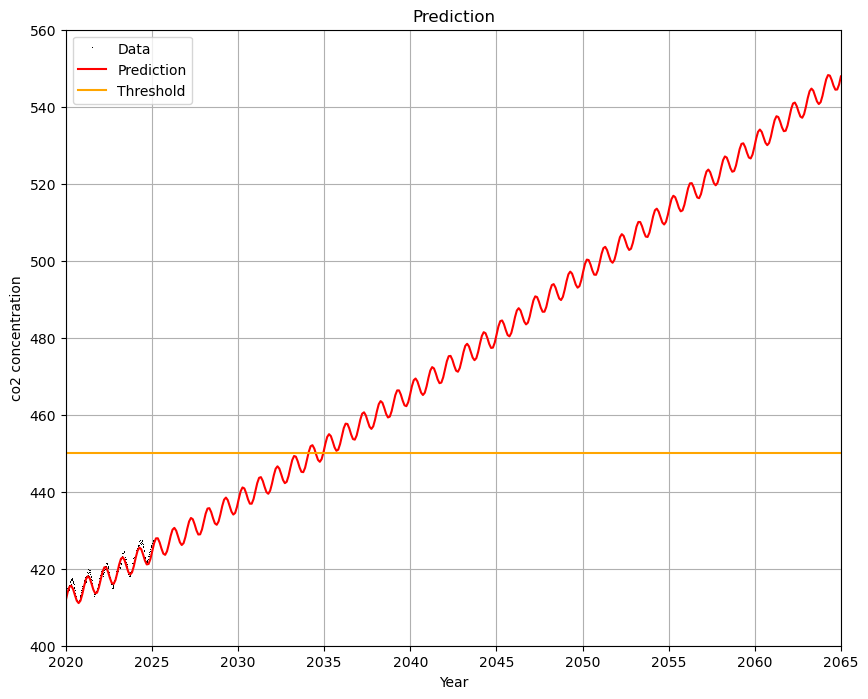

In [37]:
# Extra code cell
c0 = np.mean(inference.posterior.c0.values.flatten())
c1 = np.mean(inference.posterior.c1.values.flatten())
c2 = np.mean(inference.posterior.c2.values.flatten())
alpha = np.mean(inference.posterior.alpha.values.flatten())
phi = np.mean(inference.posterior.phi.values.flatten())
x = np.linspace(years_min, 2065, 1000)

# Visualize the prediction
plt.figure(figsize = (10, 8))
plt.plot(years, co2, 'k,', label = 'Data')
plt.plot(x, (c0 + c1*((x-years_min)/(years_range)) + c2*((x-years_min)/(years_range))**2 + alpha*np.cos(2*np.pi*years_range*((x-years_min)/(years_range)) + phi))* co2_range + co2_min, label='Prediction', color='r')
plt.axhline(450, label = 'Threshold', c='orange') 
plt.title('Prediction')
plt.xlabel('Year')
plt.ylabel('co2 concentration')
plt.xlim(2020, 2065)
plt.ylim(400)
plt.grid()
plt.legend()
plt.show()




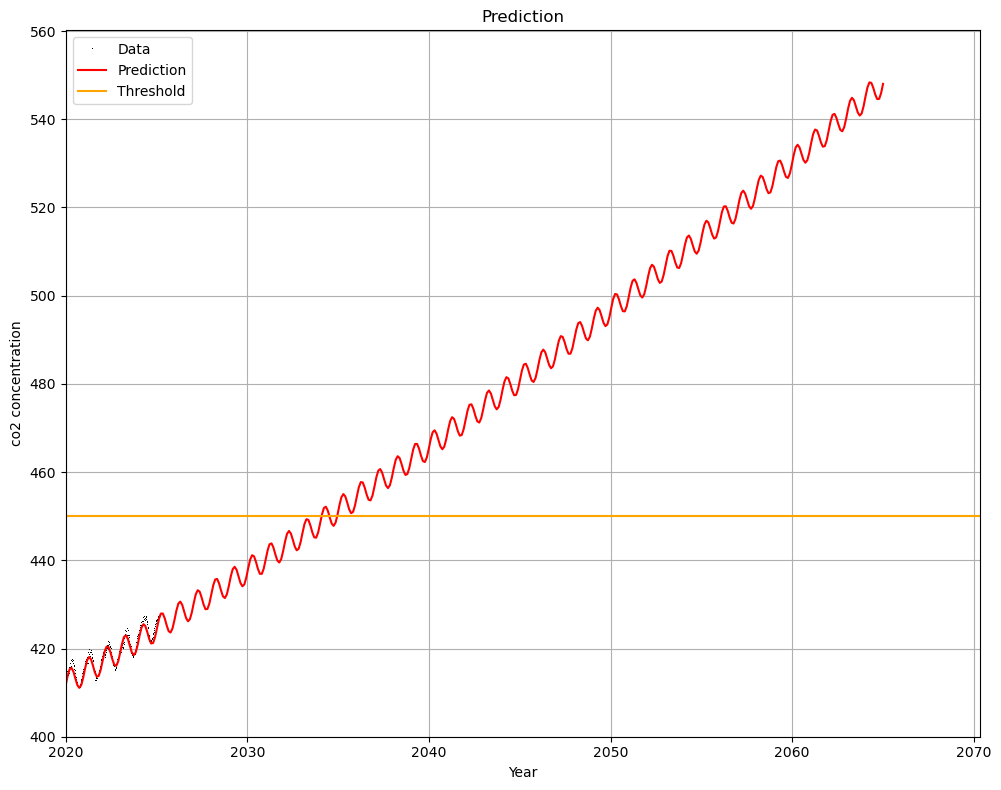

In [45]:
# Extra code cell
c0 = np.mean(inference.posterior.c0.values.flatten())
c1 = np.mean(inference.posterior.c1.values.flatten())
c2 = np.mean(inference.posterior.c2.values.flatten())
alpha = np.mean(inference.posterior.alpha.values.flatten())
phi = np.mean(inference.posterior.phi.values.flatten())
x = np.linspace(years_min, 2065, 1000)

# Visualize the prediction
plt.figure(figsize = (10, 8))
plt.plot(years, co2, 'k,', label = 'Data')
plt.plot(x, (c0 + c1*((x-years_min)/(years_range)) + c2*((x-years_min)/(years_range))**2 + alpha*np.cos(2*np.pi*years_range*((x-years_min)/(years_range)) + phi))* co2_range + co2_min, label='Prediction', color='r')
plt.axhline(450, label = 'Threshold', c='orange') 
plt.title('Prediction')
plt.xlabel('Year')
plt.ylabel('co2 concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.ylim(400)
plt.xlim(2020)
plt.show()